One of the "underdocumented", and perhaps lesser known, features of the RDKit MCS code is the ability to take atomic coordinates into account when generating the MCS. The idea here is to find the MCS between a set of 3D molecules where the distance between potential matching atoms is taken into account.

This blog post shows how to do it.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_3d = True
import rdkit
print(rdkit.__version__)

2022.03.3


Let's start with an artifical example as a demo:

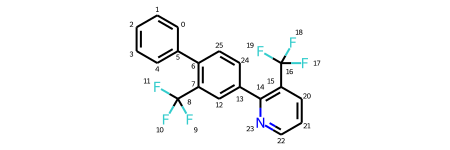

In [2]:
m1 = Chem.MolFromSmiles('c1ccccc1-c1c(C(F)(F)F)cc(-c2c(C(F)(F)F)cccn2)cc1')
IPythonConsole.drawOptions.addAtomIndices = True
m1

Generate a conformer:

In [3]:
m1 = Chem.AddHs(m1)
rdDistGeom.EmbedMolecule(m1,randomSeed=0xf00d)
m1 = Chem.RemoveHs(m1)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

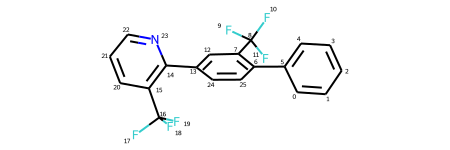

In [4]:
m1

Clip out the central ring and change one of the atoms to an N

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

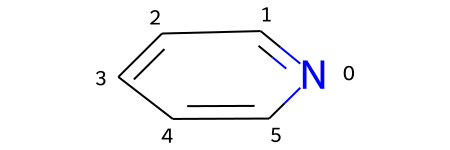

In [5]:
m2 = Chem.RWMol(m1)
keep = [6,7,12,13,24,25]
remove = set(range(m2.GetNumAtoms())).difference(keep)
m2.BeginBatchEdit()
for aidx in remove:
    m2.RemoveAtom(aidx)
m2.CommitBatchEdit()
m2.GetAtomWithIdx(0).SetAtomicNum(7)
m2

A normal MCS will, of course, match this to the N-containing ring:

In [6]:
ps = rdFMCS.MCSParameters()
res = rdFMCS.FindMCS([m1,m2],ps)
print(res.smartsString)

[#7]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


In [7]:
ps = rdFMCS.MCSParameters()
ps.AtomCompareParameters.MaxDistance = 0.5
res = rdFMCS.FindMCS([m1,m2],ps)
print(res.smartsString)

[#6]:[#6]:[#6]:[#6]:[#6]


In [8]:
ps = rdFMCS.MCSParameters()
ps.AtomCompareParameters.MaxDistance = 0.5
ps.AtomTyper = rdFMCS.AtomCompare.CompareAny
res = rdFMCS.FindMCS([m1,m2],ps)
print(res.smartsString)

[#7,#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


# A real example

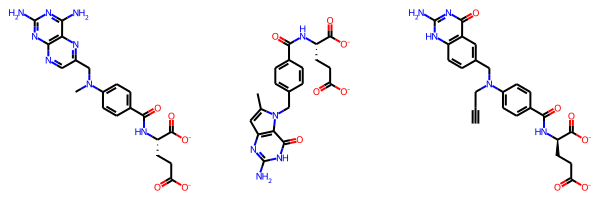

In [9]:
# exported from the binding db and converted to SDF in pymol
ms = [x for x in Chem.ForwardSDMolSupplier('../data/1TDU-results.sdf')]
ms2d = [Chem.Mol(x) for x in ms]
for m in ms2d:
    rdDepictor.Compute2DCoords(m)
IPythonConsole.drawOptions.addAtomIndices = False
Draw.MolsToGridImage(ms2d)

In [10]:
import py3Dmol
viewer = py3Dmol.view(width=350, height=350)
IPythonConsole.addMolToView(ms[0],viewer)
IPythonConsole.addMolToView(ms[1],viewer)
IPythonConsole.addMolToView(ms[2],viewer)
viewer.zoomTo()
viewer.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

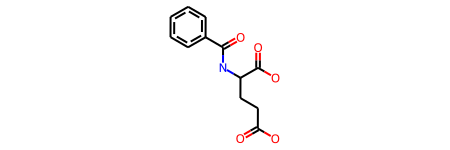

In [11]:
ps = rdFMCS.MCSParameters()
res = rdFMCS.FindMCS(ms,ps)
qry = Chem.MolFromSmarts(res.smartsString)
qry

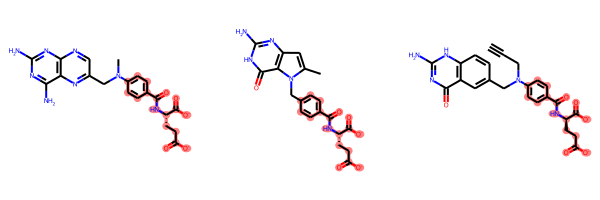

In [12]:
matches = [x.GetSubstructMatch(qry) for x in ms2d]

conf = Chem.Conformer(qry.GetNumAtoms())
for i,mi in enumerate(matches[0]):
    conf.SetAtomPosition(i,ms2d[0].GetConformer().GetAtomPosition(mi))
qry.AddConformer(conf)

rdDepictor.SetPreferCoordGen(False) # coordgen doesn't always obey the scaffold, so switch to the RDKit coordinates
for m in ms2d:
    rdDepictor.GenerateDepictionMatching2DStructure(m,qry)
rdDepictor.SetPreferCoordGen(True)
Draw.MolsToGridImage(ms2d,highlightAtomLists=matches)

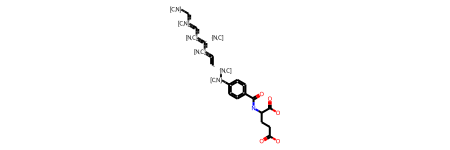

In [13]:
ps = rdFMCS.MCSParameters()
ps.AtomTyper = rdFMCS.AtomCompare.CompareAny
res = rdFMCS.FindMCS(ms,ps)
qry = Chem.MolFromSmarts(res.smartsString)
qry


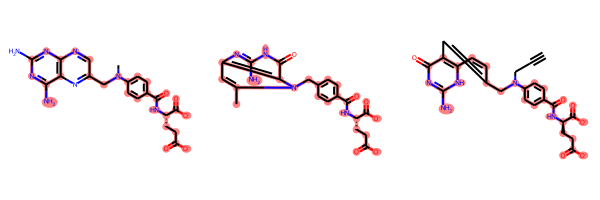

In [14]:
matches = [x.GetSubstructMatch(qry) for x in ms2d]

conf = Chem.Conformer(qry.GetNumAtoms())
for i,mi in enumerate(matches[0]):
    conf.SetAtomPosition(i,ms2d[0].GetConformer().GetAtomPosition(mi))
qry.AddConformer(conf)
rdDepictor.SetPreferCoordGen(False) # coordgen doesn't always obey the scaffold, so switch to the RDKit coordinates
for m in ms2d:
    rdDepictor.GenerateDepictionMatching2DStructure(m,qry)
rdDepictor.SetPreferCoordGen(True)

Draw.MolsToGridImage(ms2d,highlightAtomLists=matches)


This is an example where the constrained coordinates, which only match part of a ring system, cause problems.

Both of those MCS results are matching significant parts of the molecules, but we saw that the molecules didn't actually align quite that well.

What about if we take atom coordinates into account?

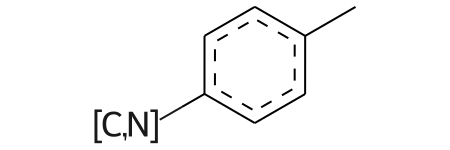

In [15]:
ps = rdFMCS.MCSParameters()
ps.AtomCompareParameters.MaxDistance = 1.0
ps.AtomTyper = rdFMCS.AtomCompare.CompareAny
res = rdFMCS.FindMCS(ms,ps)
qry = Chem.MolFromSmarts(res.smartsString)
qry


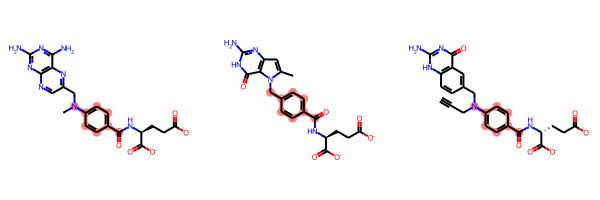

In [16]:
matches = [x.GetSubstructMatch(qry) for x in ms2d]

conf = Chem.Conformer(qry.GetNumAtoms())
for i,mi in enumerate(matches[0]):
    conf.SetAtomPosition(i,ms2d[0].GetConformer().GetAtomPosition(mi))
qry.AddConformer(conf)
for m in ms2d:
    rdDepictor.GenerateDepictionMatching2DStructure(m,qry)
Draw.MolsToGridImage(ms2d,highlightAtomLists=matches)

The MCS gave us a SMARTS which matches, but unfortunately it does not provide the matching atoms. Finding those via substructure search would be easy if we could assume that the MCS only matches each molecule once, but that's not always going to be the case.

This is actually one of those examples.

Let's look at how many times the core can match each of the molecules:

In [17]:
allMatches = []
for m in ms:
    allMatches.append(m.GetSubstructMatches(qry,uniquify=False))
allMatches

[((13, 15, 17, 16, 20, 19, 18, 21), (13, 15, 18, 19, 20, 16, 17, 21)),
 ((12, 13, 15, 14, 18, 17, 16, 19),
  (12, 13, 16, 17, 18, 14, 15, 19),
  (19, 18, 14, 15, 13, 16, 17, 12),
  (19, 18, 17, 16, 13, 15, 14, 12)),
 ((13, 14, 17, 18, 19, 20, 21, 22), (13, 14, 21, 20, 19, 18, 17, 22))]

Now define a function which goes through all the possible substructure matches and finds the one which satisfies the 3D distance constraints on the core:

In [18]:
def getAlignedSubstructMatch(ms,qry,distTol=1.0):
    allMatches = []
    for m in ms:
        allMatches.append(m.GetSubstructMatches(qry,uniquify=False))

    keepMatches = []
    for match0 in allMatches[0]:
        allMatched = True
        for i in range(1,len(ms)):
            imatched = False
            for matchi in allMatches[i]:
                matched = True
                for i0,ii in zip(match0,matchi):
                    dist = (ms[0].GetConformer().GetAtomPosition(i0) - ms[i].GetConformer().GetAtomPosition(ii)).Length()
                    if dist > distTol:
                        matched = False
                        break
                if matched:
                    keepMatches.append(matchi)
                    imatched = True
                    break
            if not imatched:
                allMatched = False
                keepMatches = []
                break
        if allMatched:
            keepMatches = [match0] + keepMatches
            break
        else:
            keepMatches = []
    return keepMatches
    


The results for our molecules and the 3D MCS core:

In [19]:
keepMatches = getAlignedSubstructMatch(ms,qry)
keepMatches

[(13, 15, 17, 16, 20, 19, 18, 21),
 (12, 13, 15, 14, 18, 17, 16, 19),
 (13, 14, 17, 18, 19, 20, 21, 22)]

And highlight the substructures:

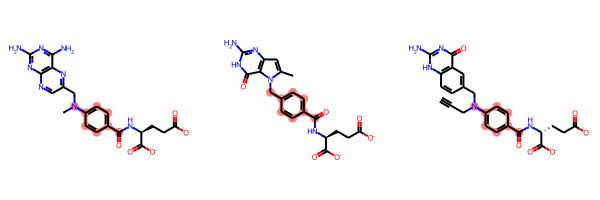

In [20]:
Draw.MolsToGridImage(ms2d,highlightAtomLists=keepMatches)

Let's redraw the molecules in 3D and highlight the atoms involved in the MCS. It's nice to see, plus I learned some stuff about how to use py3Dmol while doing it... so that's a bonus. :-)

In [21]:
import py3Dmol
viewer = py3Dmol.view(width=450, height=450)
IPythonConsole.addMolToView(ms[0],viewer)
IPythonConsole.addMolToView(ms[1],viewer)
IPythonConsole.addMolToView(ms[2],viewer)
for idx,clr in zip((-1,-2,-3),('redCarbon','cyanCarbon','blueCarbon')):
    viewer.setStyle({'model':idx,},
                    {'stick':{'colorscheme':clr,'radius':.15}})
    viewer.setStyle({'model':idx,'serial':keepMatches[idx]},
                    {'stick':{'colorscheme':clr},'sphere':{'colorscheme':clr,'radius':.5}})

viewer.zoomTo()
viewer.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol